# Recurrent Neural Networks

In [121]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Attention
from tensorflow.keras.callbacks import EarlyStopping
!pip install tensorflow transformers scikit-learn numpy pandas matplotlib seaborn
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [4]:
# Load dataset
df = pd.read_csv("FinalSentiment.csv").dropna(subset=['statement', 'sentiment_score'])

# Convert sentiment scores to categorical labels
df['sentiment_label'] = df['sentiment_score'].apply(lambda x: 2 if x > 0 else (1 if x == 0 else 0))

# Reduce dataset size to speed up processing
df_sample = df.sample(n=10000, random_state=42)

# Split data
X_train, X_test, y_train, y_test = train_test_split(df_sample['statement'], df_sample['sentiment_label'], test_size=0.2, random_state=42)

In [6]:
# Tokenization Parameters
MAX_WORDS = 5000  # Vocabulary size
MAX_LEN = 50      # Sequence length (number of words per input)

# Tokenize text
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

In [8]:
# Define RNN Model
model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=64, input_length=MAX_LEN),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 sentiment classes: positive, neutral, negative
])

# Compile Model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train Model
history = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=10, batch_size=32, callbacks=[early_stopping])

# Evaluate Model
y_pred = np.argmax(model.predict(X_test_pad), axis=1)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Epoch 1/10


C:\Users\abcd\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.4912 - loss: 0.7781 - val_accuracy: 0.4965 - val_loss: 0.6994
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5102 - loss: 0.6970 - val_accuracy: 0.5040 - val_loss: 0.6956
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5504 - loss: 0.6847 - val_accuracy: 0.4885 - val_loss: 0.7319
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6161 - loss: 0.6362 - val_accuracy: 0.5000 - val_loss: 0.7555
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6487 - loss: 0.5919 - val_accuracy: 0.4970 - val_loss: 0.7808
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Test Accuracy: 0.504


In [10]:
sequence_lengths = [30, 50, 100]
for seq_len in sequence_lengths:
    X_train_pad = pad_sequences(X_train_seq, maxlen=seq_len, padding='post')
    X_test_pad = pad_sequences(X_test_seq, maxlen=seq_len, padding='post')

    model.fit(X_train_pad, y_train, epochs=5, batch_size=32, verbose=0)
    y_pred = np.argmax(model.predict(X_test_pad), axis=1)
    
    print(f"Sequence Length {seq_len} → Accuracy: {accuracy_score(y_test, y_pred):.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Sequence Length 30 → Accuracy: 0.5075
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sequence Length 50 → Accuracy: 0.5050
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Sequence Length 100 → Accuracy: 0.5085


In [12]:
rare_terms = ["schizophrenia", "dissociation", "psychosis", "mania", "suicidal"]
test_sentences = ["I feel overwhelmed with schizophrenia thoughts.", "Experiencing dissociation daily.", "I have extreme mania today."]

test_seq = tokenizer.texts_to_sequences(test_sentences)
test_pad = pad_sequences(test_seq, maxlen=MAX_LEN, padding='post')

predictions = np.argmax(model.predict(test_pad), axis=1)

for i, sentence in enumerate(test_sentences):
    print(f"Text: {sentence} → Predicted Sentiment: {predictions[i]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Text: I feel overwhelmed with schizophrenia thoughts. → Predicted Sentiment: 0
Text: Experiencing dissociation daily. → Predicted Sentiment: 2
Text: I have extreme mania today. → Predicted Sentiment: 2


In [32]:
# Tokenization
MAX_WORDS = 3000  # Limit vocabulary size
MAX_LEN = 40      # Limit sequence length

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

C:\Users\abcd\AppData\Local\Temp\ipykernel_18596\2209025752.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette="coolwarm")


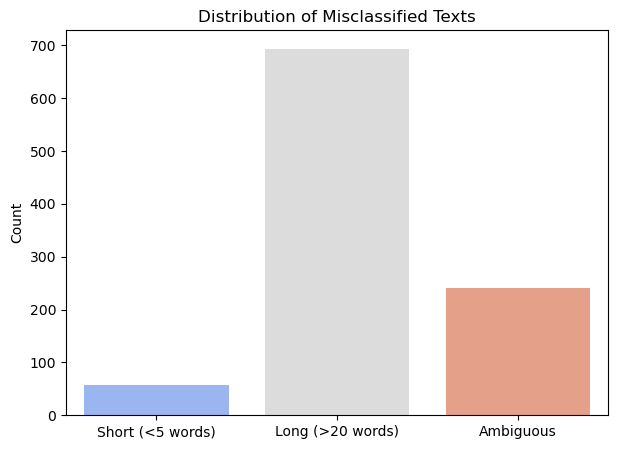

In [38]:
# Identify misclassified texts
misclassified_idx = np.where(y_pred != y_test)[0]

# Categorize errors based on text length
short_texts = []
long_texts = []
ambiguous_texts = []

for i in misclassified_idx:
    text = X_test.iloc[i]
    if len(text.split()) < 5:
        short_texts.append(text)
    elif len(text.split()) > 20:
        long_texts.append(text)
    else:
        ambiguous_texts.append(text)

# Visualize distribution
labels = ['Short (<5 words)', 'Long (>20 words)', 'Ambiguous']
counts = [len(short_texts), len(long_texts), len(ambiguous_texts)]

plt.figure(figsize=(7,5))
sns.barplot(x=labels, y=counts, palette="coolwarm")
plt.title("Distribution of Misclassified Texts")
plt.ylabel("Count")
plt.show()

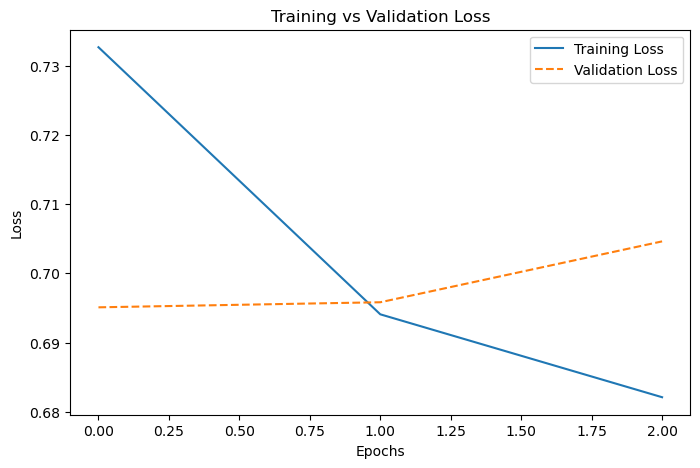

In [40]:
# Plot Training Loss & Early Stopping
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

Epoch 1/5


C:\Users\abcd\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5023 - loss: 0.7963 - val_accuracy: 0.5035 - val_loss: 0.6942
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5044 - loss: 0.6961 - val_accuracy: 0.4965 - val_loss: 0.6962
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5260 - loss: 0.6951 - val_accuracy: 0.4960 - val_loss: 0.7147
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


C:\Users\abcd\AppData\Local\Temp\ipykernel_18596\1820368624.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Single-Layer RNN', 'Multi-Layer RNN'], y=[acc_single, acc_multi], palette="magma")


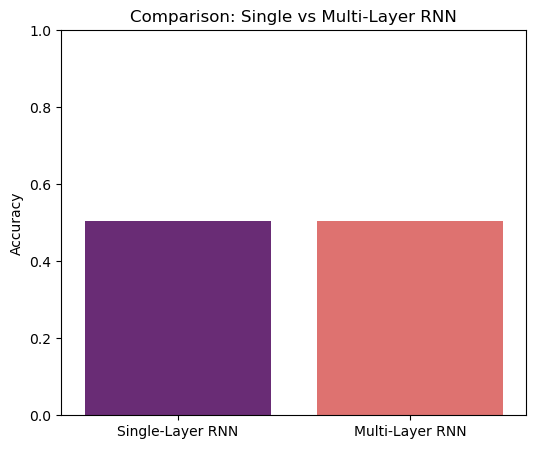

🔹 Single-Layer RNN Accuracy: 0.5035
🔹 Multi-Layer RNN Accuracy: 0.5035


In [42]:
# Define Multi-Layer RNN Model
multi_layer_model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=32, input_length=MAX_LEN),
    LSTM(32, return_sequences=True),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile Multi-Layer Model
multi_layer_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Multi-Layer Model
history_multi = multi_layer_model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=5, batch_size=32, callbacks=[early_stopping])

# Evaluate Multi-Layer Model
y_pred_multi = np.argmax(multi_layer_model.predict(X_test_pad), axis=1)
multi_accuracy = accuracy_score(y_test, y_pred_multi)

# Compare Performance
acc_single = accuracy_score(y_test, y_pred)
acc_multi = multi_accuracy

# Visualize Accuracy Comparison
plt.figure(figsize=(6,5))
sns.barplot(x=['Single-Layer RNN', 'Multi-Layer RNN'], y=[acc_single, acc_multi], palette="magma")
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Comparison: Single vs Multi-Layer RNN")
plt.show()

print("🔹 Single-Layer RNN Accuracy:", acc_single)
print("🔹 Multi-Layer RNN Accuracy:", acc_multi)

# LSTM

In [47]:
# Convert sentiment scores to categorical labels
df['sentiment_label'] = df['sentiment_score'].apply(lambda x: 2 if x > 0 else (1 if x == 0 else 0))

# Reduce dataset size for faster training
df_sample = df.sample(n=5000, random_state=42)

# Split data
X_train, X_test, y_train, y_test = train_test_split(df_sample['statement'], df_sample['sentiment_label'], test_size=0.2, random_state=42)

In [49]:
# Tokenization
MAX_WORDS = 3000  # Limit vocabulary size
MAX_LEN = 40      # Limit sequence length

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

C:\Users\abcd\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


C:\Users\abcd\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


C:\Users\abcd\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


C:\Users\abcd\AppData\Local\Temp\ipykernel_18596\87970811.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unit_sizes, y=accuracies, palette="coolwarm")


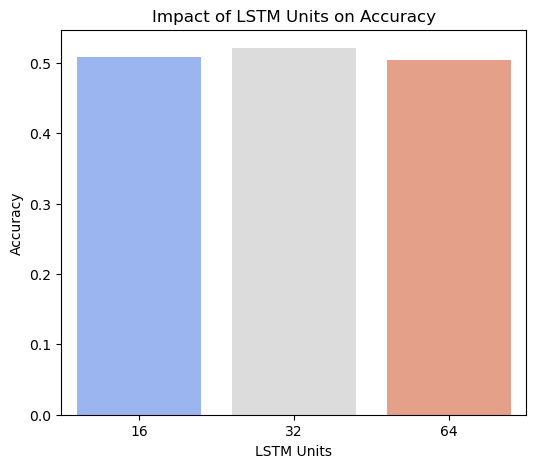

In [51]:
unit_sizes = [16, 32, 64]
accuracies = []

for units in unit_sizes:
    model = Sequential([
        Embedding(input_dim=MAX_WORDS, output_dim=32, input_length=MAX_LEN),
        LSTM(units),
        Dense(3, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train_pad, y_train, epochs=3, batch_size=32, verbose=0)
    
    y_pred = np.argmax(model.predict(X_test_pad), axis=1)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Plot results
plt.figure(figsize=(6,5))
sns.barplot(x=unit_sizes, y=accuracies, palette="coolwarm")
plt.xlabel("LSTM Units")
plt.ylabel("Accuracy")
plt.title("Impact of LSTM Units on Accuracy")
plt.show()

C:\Users\abcd\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


C:\Users\abcd\AppData\Local\Temp\ipykernel_18596\3444110465.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['LSTM', 'Naive Bayes'], y=[acc_lstm, acc_nb], palette="magma")


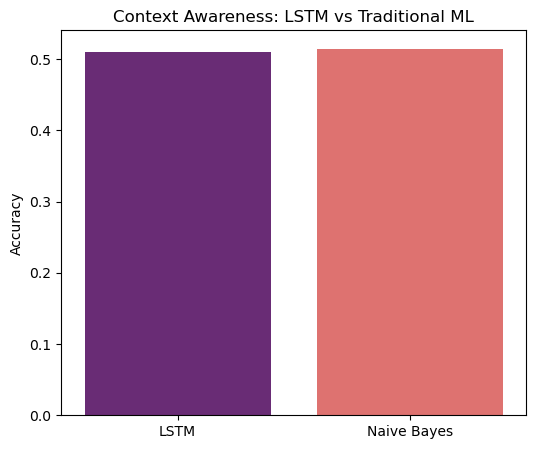

In [53]:
# LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=32, input_length=MAX_LEN),
    LSTM(32),
    Dense(3, activation='softmax')
])

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_pad, y_train, epochs=3, batch_size=32, verbose=0)

y_pred_lstm = np.argmax(lstm_model.predict(X_test_pad), axis=1)
acc_lstm = accuracy_score(y_test, y_pred_lstm)

# Compare with Naive Bayes (Traditional ML)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

vectorizer = TfidfVectorizer(max_features=3000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

y_pred_nb = nb_model.predict(X_test_tfidf)
acc_nb = accuracy_score(y_test, y_pred_nb)

# Plot Comparison
plt.figure(figsize=(6,5))
sns.barplot(x=['LSTM', 'Naive Bayes'], y=[acc_lstm, acc_nb], palette="magma")
plt.ylabel("Accuracy")
plt.title("Context Awareness: LSTM vs Traditional ML")
plt.show()

C:\Users\abcd\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


C:\Users\abcd\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


C:\Users\abcd\AppData\Local\Temp\ipykernel_18596\1160394845.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dropout_rates, y=dropout_accuracies, palette="viridis")


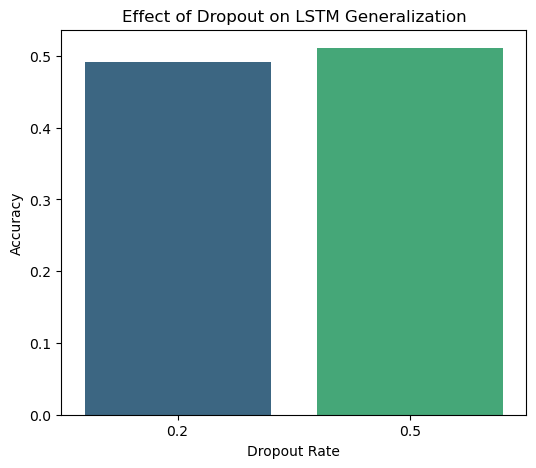

In [55]:
dropout_rates = [0.2, 0.5]
dropout_accuracies = []

for rate in dropout_rates:
    model = Sequential([
        Embedding(input_dim=MAX_WORDS, output_dim=32, input_length=MAX_LEN),
        LSTM(32, dropout=rate),
        Dense(3, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train_pad, y_train, epochs=3, batch_size=32, verbose=0)
    
    y_pred = np.argmax(model.predict(X_test_pad), axis=1)
    dropout_accuracies.append(accuracy_score(y_test, y_pred))

# Plot results
plt.figure(figsize=(6,5))
sns.barplot(x=dropout_rates, y=dropout_accuracies, palette="viridis")
plt.xlabel("Dropout Rate")
plt.ylabel("Accuracy")
plt.title("Effect of Dropout on LSTM Generalization")
plt.show()

C:\Users\abcd\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


C:\Users\abcd\AppData\Local\Temp\ipykernel_18596\1240691476.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['LSTM', 'Bi-LSTM'], y=[acc_lstm, acc_bi], palette="coolwarm")


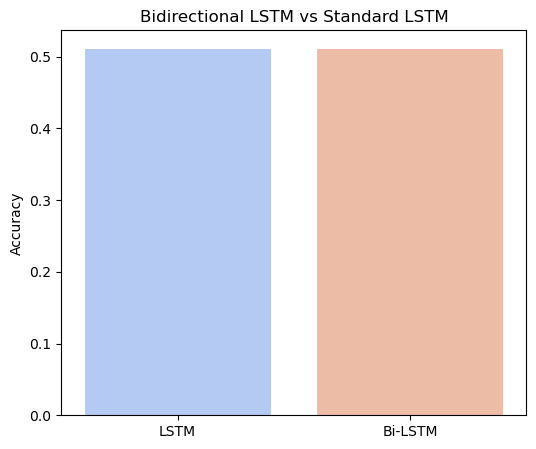

In [57]:
# Bidirectional LSTM Model
bi_lstm_model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=32, input_length=MAX_LEN),
    Bidirectional(LSTM(32)),
    Dense(3, activation='softmax')
])

bi_lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bi_lstm_model.fit(X_train_pad, y_train, epochs=3, batch_size=32, verbose=0)

y_pred_bi = np.argmax(bi_lstm_model.predict(X_test_pad), axis=1)
acc_bi = accuracy_score(y_test, y_pred_bi)

# Plot results
plt.figure(figsize=(6,5))
sns.barplot(x=['LSTM', 'Bi-LSTM'], y=[acc_lstm, acc_bi], palette="coolwarm")
plt.ylabel("Accuracy")
plt.title("Bidirectional LSTM vs Standard LSTM")
plt.show()

C:\Users\abcd\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
C:\Users\abcd\AppData\Local\Temp\ipykernel_18596\1547927120.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=batch_sizes, y=train_times, palette="rocket")


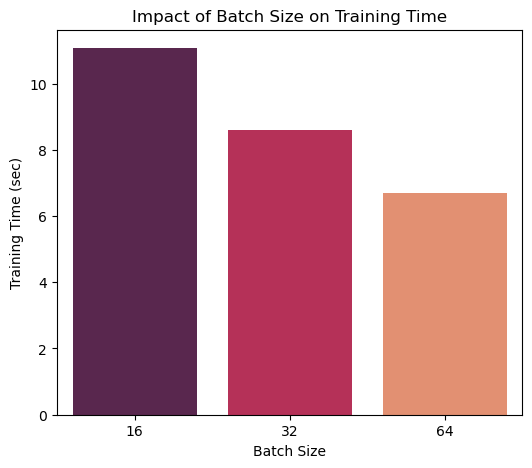

In [59]:
batch_sizes = [16, 32, 64]
train_times = []

for batch in batch_sizes:
    model = Sequential([
        Embedding(input_dim=MAX_WORDS, output_dim=32, input_length=MAX_LEN),
        LSTM(32),
        Dense(3, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    import time
    start = time.time()
    model.fit(X_train_pad, y_train, epochs=3, batch_size=batch, verbose=0)
    end = time.time()
    
    train_times.append(end - start)

# Plot results
plt.figure(figsize=(6,5))
sns.barplot(x=batch_sizes, y=train_times, palette="rocket")
plt.xlabel("Batch Size")
plt.ylabel("Training Time (sec)")
plt.title("Impact of Batch Size on Training Time")
plt.show()

In [61]:
from tensorflow.keras.layers import Attention

# Simple Attention Model
input_layer = tf.keras.layers.Input(shape=(MAX_LEN,))
embedding = Embedding(input_dim=MAX_WORDS, output_dim=32)(input_layer)
lstm = LSTM(32, return_sequences=True)(embedding)
attention = Attention()([lstm, lstm])
output = Dense(3, activation='softmax')(tf.keras.layers.Flatten()(attention))

attention_model = tf.keras.Model(inputs=input_layer, outputs=output)
attention_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
attention_model.fit(X_train_pad, y_train, epochs=3, batch_size=32, verbose=0)

y_pred_att = np.argmax(attention_model.predict(X_test_pad), axis=1)
print("Accuracy with Attention:", accuracy_score(y_test, y_pred_att))

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Accuracy with Attention: 0.489


# Convolutional Neural Networks

In [66]:
# Convert sentiment scores to categorical labels
df['sentiment_label'] = df['sentiment_score'].apply(lambda x: 2 if x > 0 else (1 if x == 0 else 0))

# Reduce dataset size for faster training
df_sample = df.sample(n=5000, random_state=42)

# Split data
X_train, X_test, y_train, y_test = train_test_split(df_sample['statement'], df_sample['sentiment_label'], test_size=0.2, random_state=42)

In [68]:
# Tokenization
MAX_WORDS = 3000  # Limit vocabulary size
MAX_LEN = 40      # Limit sequence length

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

C:\Users\abcd\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


C:\Users\abcd\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


C:\Users\abcd\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


C:\Users\abcd\AppData\Local\Temp\ipykernel_18596\2109293605.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=filter_sizes, y=accuracies, palette="coolwarm")


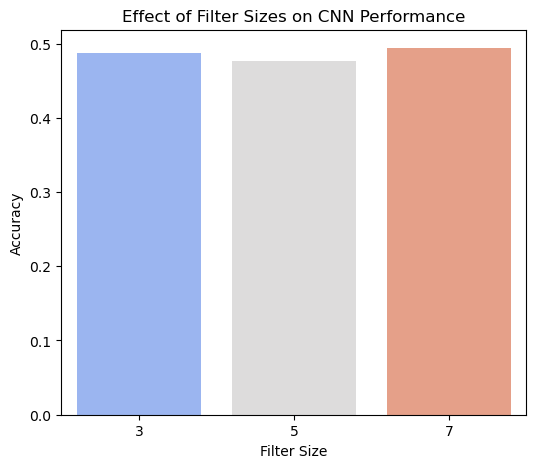

In [70]:
filter_sizes = [3, 5, 7]
accuracies = []

for filter_size in filter_sizes:
    model = Sequential([
        Embedding(input_dim=MAX_WORDS, output_dim=32, input_length=MAX_LEN),
        Conv1D(filters=64, kernel_size=filter_size, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(3, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train_pad, y_train, epochs=3, batch_size=32, verbose=0)
    
    y_pred = np.argmax(model.predict(X_test_pad), axis=1)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Plot results
plt.figure(figsize=(6,5))
sns.barplot(x=filter_sizes, y=accuracies, palette="coolwarm")
plt.xlabel("Filter Size")
plt.ylabel("Accuracy")
plt.title("Effect of Filter Sizes on CNN Performance")
plt.show()

C:\Users\abcd\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


C:\Users\abcd\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


C:\Users\abcd\AppData\Local\Temp\ipykernel_18596\1816391509.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Max-Pooling', 'Average-Pooling'], y=[acc_max, acc_avg], palette="magma")


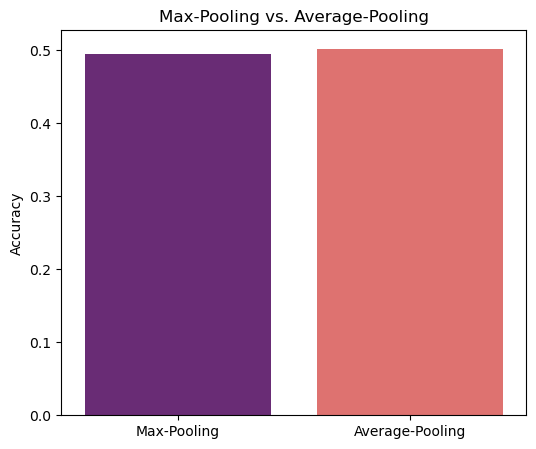

In [72]:
# Max-Pooling Model
max_pool_model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=32, input_length=MAX_LEN),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(3, activation='softmax')
])

max_pool_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
max_pool_model.fit(X_train_pad, y_train, epochs=3, batch_size=32, verbose=0)

y_pred_max = np.argmax(max_pool_model.predict(X_test_pad), axis=1)
acc_max = accuracy_score(y_test, y_pred_max)

# Average-Pooling Model
avg_pool_model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=32, input_length=MAX_LEN),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(3, activation='softmax')
])

avg_pool_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
avg_pool_model.fit(X_train_pad, y_train, epochs=3, batch_size=32, verbose=0)

y_pred_avg = np.argmax(avg_pool_model.predict(X_test_pad), axis=1)
acc_avg = accuracy_score(y_test, y_pred_avg)

# Plot results
plt.figure(figsize=(6,5))
sns.barplot(x=['Max-Pooling', 'Average-Pooling'], y=[acc_max, acc_avg], palette="magma")
plt.ylabel("Accuracy")
plt.title("Max-Pooling vs. Average-Pooling")
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


C:\Users\abcd\AppData\Local\Temp\ipykernel_18596\267050598.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['CNN', 'LSTM'], y=[acc_cnn, acc_lstm], palette="coolwarm")


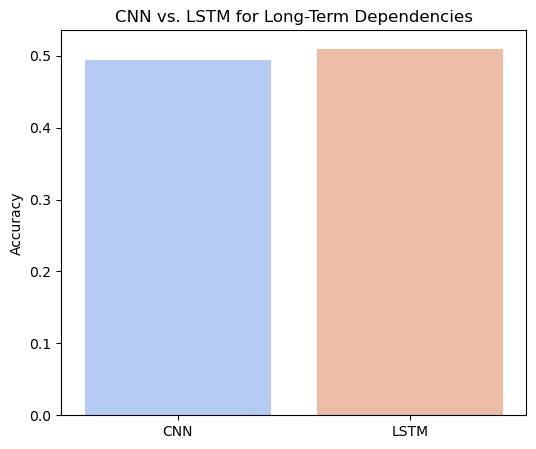

In [74]:
# Compare CNN with LSTM (from previous implementation)
y_pred_cnn = np.argmax(max_pool_model.predict(X_test_pad), axis=1)
acc_cnn = accuracy_score(y_test, y_pred_cnn)

# Load pre-trained LSTM model (from previous code)
y_pred_lstm = np.argmax(lstm_model.predict(X_test_pad), axis=1)
acc_lstm = accuracy_score(y_test, y_pred_lstm)

# Plot comparison
plt.figure(figsize=(6,5))
sns.barplot(x=['CNN', 'LSTM'], y=[acc_cnn, acc_lstm], palette="coolwarm")
plt.ylabel("Accuracy")
plt.title("CNN vs. LSTM for Long-Term Dependencies")
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abcd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\abcd\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


C:\Users\abcd\AppData\Local\Temp\ipykernel_18596\2475657670.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['With Stopwords', 'Without Stopwords'], y=[acc_cnn, acc_clean], palette="rocket")


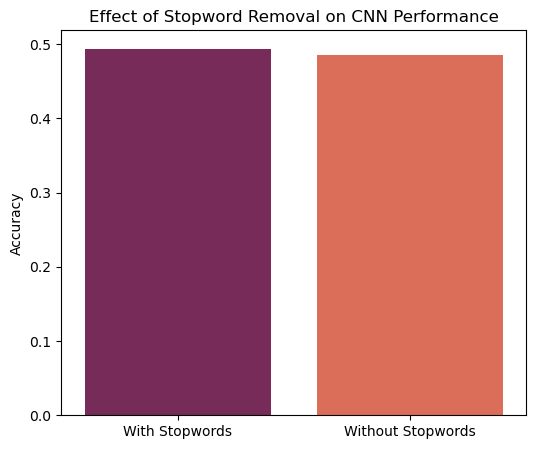

In [76]:
# Remove stopwords and re-train CNN
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
X_train_clean = [' '.join([word for word in text.split() if word.lower() not in stop_words]) for text in X_train]
X_test_clean = [' '.join([word for word in text.split() if word.lower() not in stop_words]) for text in X_test]

X_train_clean_seq = tokenizer.texts_to_sequences(X_train_clean)
X_test_clean_seq = tokenizer.texts_to_sequences(X_test_clean)

X_train_clean_pad = pad_sequences(X_train_clean_seq, maxlen=MAX_LEN, padding='post')
X_test_clean_pad = pad_sequences(X_test_clean_seq, maxlen=MAX_LEN, padding='post')

# Train CNN
clean_cnn_model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=32, input_length=MAX_LEN),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(3, activation='softmax')
])

clean_cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
clean_cnn_model.fit(X_train_clean_pad, y_train, epochs=3, batch_size=32, verbose=0)

y_pred_clean = np.argmax(clean_cnn_model.predict(X_test_clean_pad), axis=1)
acc_clean = accuracy_score(y_test, y_pred_clean)

# Plot results
plt.figure(figsize=(6,5))
sns.barplot(x=['With Stopwords', 'Without Stopwords'], y=[acc_cnn, acc_clean], palette="rocket")
plt.ylabel("Accuracy")
plt.title("Effect of Stopword Removal on CNN Performance")
plt.show()

# Bidirectional LSTM

In [85]:
# Convert sentiment scores to categorical labels
df['sentiment_label'] = df['sentiment_score'].apply(lambda x: 2 if x > 0 else (1 if x == 0 else 0))

# Reduce dataset size for faster training
df_sample = df.sample(n=5000, random_state=42)

# Split data
X_train, X_test, y_train, y_test = train_test_split(df_sample['statement'], df_sample['sentiment_label'], test_size=0.2, random_state=42)

In [87]:
# Tokenization
MAX_WORDS = 5000  # Vocabulary size
MAX_LEN = 50      # Sentence length

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

C:\Users\abcd\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


C:\Users\abcd\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


C:\Users\abcd\AppData\Local\Temp\ipykernel_18596\3249802253.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['LSTM', 'BiLSTM'], y=[acc_lstm, acc_bilstm], palette="coolwarm")


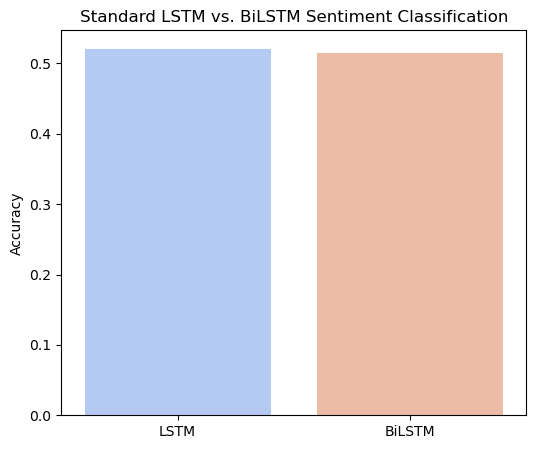

In [89]:
# Standard LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=64, input_length=MAX_LEN),
    LSTM(64, return_sequences=False),
    Dense(3, activation='softmax')
])

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_pad, y_train, epochs=3, batch_size=32, verbose=0)

y_pred_lstm = np.argmax(lstm_model.predict(X_test_pad), axis=1)
acc_lstm = accuracy_score(y_test, y_pred_lstm)

# BiLSTM Model
bilstm_model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=64, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(3, activation='softmax')
])

bilstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bilstm_model.fit(X_train_pad, y_train, epochs=3, batch_size=32, verbose=0)

y_pred_bilstm = np.argmax(bilstm_model.predict(X_test_pad), axis=1)
acc_bilstm = accuracy_score(y_test, y_pred_bilstm)

# Plot comparison
plt.figure(figsize=(6,5))
sns.barplot(x=['LSTM', 'BiLSTM'], y=[acc_lstm, acc_bilstm], palette="coolwarm")
plt.ylabel("Accuracy")
plt.title("Standard LSTM vs. BiLSTM Sentiment Classification")
plt.show()

In [91]:
# Sample text analysis
sample_texts = [
    "I feel a little anxious but mostly fine",
    "Today is just okay, nothing special",
    "I am happy but also worried about tomorrow"
]

sample_seq = tokenizer.texts_to_sequences(sample_texts)
sample_pad = pad_sequences(sample_seq, maxlen=MAX_LEN, padding='post')

preds = np.argmax(bilstm_model.predict(sample_pad), axis=1)

for text, sentiment in zip(sample_texts, preds):
    print(f"Text: {text} | Predicted Sentiment: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Text: I feel a little anxious but mostly fine | Predicted Sentiment: 2
Text: Today is just okay, nothing special | Predicted Sentiment: 2
Text: I am happy but also worried about tomorrow | Predicted Sentiment: 2


In [95]:
# Predict sentiment for long texts
long_texts = [
    "I have been feeling really down lately, and nothing seems to help. I try to stay positive, but it's difficult.",
    "Life is tough but I am trying to keep going despite all the struggles and challenges."
]

long_seq = tokenizer.texts_to_sequences(long_texts)
long_pad = pad_sequences(long_seq, maxlen=MAX_LEN, padding='post')

y_pred_long_bilstm = np.argmax(bilstm_model.predict(long_pad), axis=1)

# Compare results
print("BiLSTM Predictions:", y_pred_long_bilstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
BiLSTM Predictions: [2 0]


C:\Users\abcd\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


C:\Users\abcd\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


C:\Users\abcd\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


C:\Users\abcd\AppData\Local\Temp\ipykernel_18596\208923603.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=embed_sizes, y=accuracies, palette="magma")


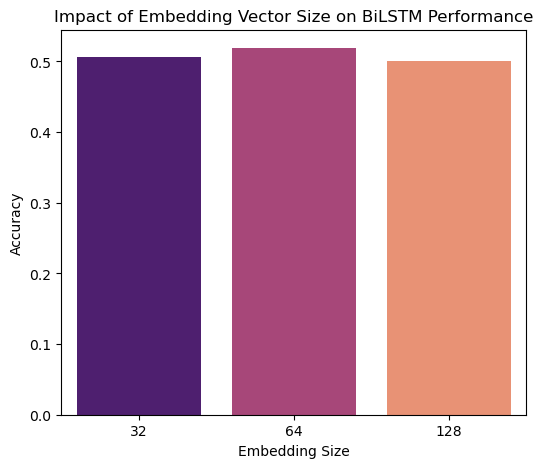

In [97]:
embed_sizes = [32, 64, 128]
accuracies = []

for size in embed_sizes:
    model = Sequential([
        Embedding(input_dim=MAX_WORDS, output_dim=size, input_length=MAX_LEN),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dense(3, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train_pad, y_train, epochs=3, batch_size=32, verbose=0)
    
    y_pred = np.argmax(model.predict(X_test_pad), axis=1)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Plot results
plt.figure(figsize=(6,5))
sns.barplot(x=embed_sizes, y=accuracies, palette="magma")
plt.xlabel("Embedding Size")
plt.ylabel("Accuracy")
plt.title("Impact of Embedding Vector Size on BiLSTM Performance")
plt.show()

# Transformers (BERT, RoBERTa, DistilBERT)

In [123]:
# Convert sentiment scores to categories
df['sentiment_label'] = df['sentiment_score'].apply(lambda x: 2 if x > 0 else (1 if x == 0 else 0))

# Sample a smaller dataset for faster processing
df_sample = df.sample(n=3000, random_state=42)

# Split dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_sample['statement'], df_sample['sentiment_label'], test_size=0.2, random_state=42
)

In [125]:
# Use TF-IDF to convert text into numerical features
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
train_vectors = vectorizer.fit_transform(train_texts)
test_vectors = vectorizer.transform(test_texts)

In [127]:
# Train Naïve Bayes classifier
model = MultinomialNB()
model.fit(train_vectors, train_labels)

# Predict on test data
predictions = model.predict(test_vectors)

# Evaluate model performance
accuracy = accuracy_score(test_labels, predictions)
print(f"Model Accuracy: {accuracy:.2f}")
print(classification_report(test_labels, predictions))

Model Accuracy: 0.51
              precision    recall  f1-score   support

           0       0.51      0.31      0.39       299
           2       0.50      0.69      0.58       301

    accuracy                           0.51       600
   macro avg       0.51      0.50      0.49       600
weighted avg       0.51      0.51      0.49       600



In [131]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=500)
lr_model.fit(train_vectors, train_labels)

# Predict & evaluate
lr_preds = lr_model.predict(test_vectors)
lr_accuracy = accuracy_score(test_labels, lr_preds)

print(f"Naïve Bayes Accuracy: {accuracy:.2f}")
print(f"Logistic Regression Accuracy: {lr_accuracy:.2f}")

Naïve Bayes Accuracy: 0.51
Logistic Regression Accuracy: 0.47


In [133]:
sarcasm_texts = [
    "Oh great, another fantastic day!", 
    "I totally love waiting in traffic.",
    "Yeah, I'm completely fine... not."
]

# Convert sarcasm texts to vectors & predict
sarcasm_vectors = vectorizer.transform(sarcasm_texts)
sarcasm_preds = model.predict(sarcasm_vectors)

# Display results
for text, sentiment in zip(sarcasm_texts, sarcasm_preds.tolist()):
    print(f"Text: {text} | Predicted Sentiment: {sentiment}")

Text: Oh great, another fantastic day! | Predicted Sentiment: 0
Text: I totally love waiting in traffic. | Predicted Sentiment: 2
Text: Yeah, I'm completely fine... not. | Predicted Sentiment: 2


In [135]:
# Use simple word count (Bag of Words)
count_vectorizer = CountVectorizer(stop_words="english", max_features=5000)
count_train_vectors = count_vectorizer.fit_transform(train_texts)
count_test_vectors = count_vectorizer.transform(test_texts)

# Train model using word count features
count_model = MultinomialNB()
count_model.fit(count_train_vectors, train_labels)
count_preds = count_model.predict(count_test_vectors)

# Evaluate
count_acc = accuracy_score(test_labels, count_preds)

print(f"TF-IDF Accuracy: {accuracy:.2f}")
print(f"Word Count Accuracy: {count_acc:.2f}")

TF-IDF Accuracy: 0.51
Word Count Accuracy: 0.50


In [137]:
# Use larger dataset (5000 samples)
df_large_sample = df.sample(n=5000, random_state=42)

# Re-train model with more data
train_texts_large, _, train_labels_large, _ = train_test_split(
    df_large_sample['statement'], df_large_sample['sentiment_label'], test_size=0.2, random_state=42
)

# Vectorize again
train_vectors_large = vectorizer.fit_transform(train_texts_large)

# Train model
model_large = MultinomialNB()
model_large.fit(train_vectors_large, train_labels_large)

# Predict & compare accuracy
large_preds = model_large.predict(test_vectors)
large_acc = accuracy_score(test_labels, large_preds)

print(f"Small Dataset Accuracy: {accuracy:.2f}")
print(f"Larger Dataset Accuracy: {large_acc:.2f}")

Small Dataset Accuracy: 0.51
Larger Dataset Accuracy: 0.50


In [139]:
# Get misclassified samples
misclassified_indices = np.where(predictions != test_labels)[0]
misclassified_texts = [test_texts.iloc[i] for i in misclassified_indices]

# Print examples
print("Examples of Misclassified Sentences:")
for text in misclassified_texts[:5]:
    print("-", text)

Examples of Misclassified Sentences:
- post grad application and butter fingers i applied for a masters program in a field that i?m really passionate about. i was actually accepted into the program the year before but because of funding issues, i had to turn down the offer. 

this year i made sure to apply for many different scholarship and have managed to secure partial funding at least so it seemed like everything was looking up for me! 

then last month my laptop was stolen (really scary situation that i?m not gonna into detail about) and i?ve had to email the university using my cell phone instead of my laptop like usual. i realized i?ve been sending draft emails through to the admissions office and associate prof while i was trying to save them and i genuinely just want to cry and give up. 

it?s such a stupid mistake and given the lack of response on the professor?s part i?m thinking this might ruin my chances. i was so proud of my personal statement and had really solid referenc